In [1]:
!pip install datasets
# Install the vncorenlp python wrapper
!pip install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter)
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=d1f4bf4b69d34352e86d11387d36b3f3f77f26182401846e1a839a5e52d1bb05
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp
--2023-12-17 20:06:39--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP req

# Load pretrained Vietnamese Word2vec

In [2]:
# Download and create new word2vec file without first information line
!wget https://public.vinai.io/word2vec_vi_words_100dims.zip
!unzip word2vec_vi_words_100dims.zip

from tqdm import tqdm

with open("word2vec_vi_words_100dims.txt", "r") as f:
    first_line = f.readline()
    num_words, dim = [int(word) for word in first_line.split()]
    print("Create word embedding file...")
    with open("vi_word2vec.txt", "w") as f_out:
        for i in tqdm(range(num_words)):
            f_out.write(f.readline())

--2023-12-17 20:06:41--  https://public.vinai.io/word2vec_vi_words_100dims.zip
Resolving public.vinai.io (public.vinai.io)... 13.33.88.57, 13.33.88.9, 13.33.88.7, ...
Connecting to public.vinai.io (public.vinai.io)|13.33.88.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 785783878 (749M) [application/zip]
Saving to: ‘word2vec_vi_words_100dims.zip’

word2vec_vi_words_1 100%[===================>] 749.38M  57.8MB/s    in 12s     

2023-12-17 20:06:53 (62.6 MB/s) - ‘word2vec_vi_words_100dims.zip’ saved [785783878/785783878]

Archive:  word2vec_vi_words_100dims.zip
  inflating: word2vec_vi_words_100dims.txt  
Create word embedding file...


100%|██████████| 1587507/1587507 [00:14<00:00, 110736.52it/s]


In [3]:
import torch
import torchtext.vocab as vocab

word_embedding = vocab.Vectors(name = "vi_word2vec.txt",
                               unk_init = torch.Tensor.normal_)
word_embedding.vectors.shape

100%|█████████▉| 1587506/1587507 [01:59<00:00, 13230.43it/s]


torch.Size([1587507, 100])

# Vocabulary

In [4]:
from itertools import chain
from collections import Counter
import torch
from tqdm import tqdm
from vncorenlp import VnCoreNLP

rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

class Vocabulary:
    """ The Vocabulary class is used to record words, which are used to convert
        text to numbers and vice versa.
    """
    def __init__(self):
        self.word2id = dict()
        self.word2id['<pad>'] = 0   # Pad Token
        self.word2id['<unk>'] = 1   # Unknown Token
        self.unk_id = self.word2id['<unk>']
        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem__(self, word):
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        return word in self.word2id

    def __len__(self):
        return len(self.word2id)

    def id2word(self, word_index):
        """
        @param word_index (int)
        @return word (str)
        """
        return self.id2word[word_index]

    def add(self, word):
        """ Add word to vocabulary
        @param word (str)
        @return index (str): index of the word just added
        """
        if word not in self:
            word_index = self.word2id[word] = len(self.word2id)
            self.id2word[word_index] = word
            return word_index
        else:
            return self[word]

    @staticmethod
    def tokenize_sentence(sentence):
        """Split the sentence into words
        @param sentence (str): input sentence
        @return tokenized_sentence (list(str)): list of words
        """
        # tokenized_sentence = [word.replace(" ", "_") for word in tokenize(sentence)]
        tokenized_sentence = rdrsegmenter.tokenize(sentence)[0]
        return tokenized_sentence

    def sentence_to_tensor(self, sentence, is_tokenized=False):
        """Convert a sentence to an indices tensor
        @param sentence (str if is_tokenized==False else list(str)): input sentence
        @param is_tokenized (bool)
        @return indices_tensor (torch.Tensor): tensor of indices
        """
        if is_tokenized:
            tokenized_sentence = sentence
        else:
            tokenized_sentence = self.tokenize_sentence(sentence)

        indices_tensor = torch.tensor([self[word] for word in tokenized_sentence],
                                      dtype=torch.int64)

        return indices_tensor

    def tensor_to_sentence(self, indices_tensor):
        """Convert an indices tensor to a sentence
        @param indices_tensor (torch.Tensor): tensor of indices
        @return sentence (str): reconstructed sentence
        """
        sentence = [self.idx2word[idx.item()] for idx in indices_tensor]
        sentence = ' '.join(sentence)

        return sentence

In [5]:
vocab = Vocabulary()

# create vocabulary from pretrained word2vec
words_list = list(word_embedding.stoi.keys())
for word in words_list:
    vocab.add(word)

# Load Dataset

In [6]:
from datasets import load_dataset

dataset = load_dataset("uitnlp/vietnamese_students_feedback")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
from torch.utils.data import Dataset
import torch

class VSFC_Dataset(Dataset):
    def __init__(self, data, vocab, max_len=64):
        self.data = data
        self.vocab = vocab
        self.pad_idx = vocab["<pad>"]
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentences = self.data[index]['sentence']
        sentiment = self.data[index]['sentiment']
        topic = self.data[index]['topic']

        tensor_data = self.vocab.sentence_to_tensor(sentences, is_tokenized=False)

        # Truncate or pad tensor_data to max_len
        if len(tensor_data) > self.max_len:
            tensor_data = tensor_data[:self.max_len]
        elif len(tensor_data) < self.max_len:
            padding = torch.full((self.max_len - len(tensor_data),), self.pad_idx)
            tensor_data = torch.cat((tensor_data, padding))

        tensor_sentiment = torch.tensor(sentiment, dtype=torch.float64)
        tensor_topic = torch.tensor(topic, dtype=torch.float64)

        return tensor_data, tensor_sentiment, tensor_topic

    def collate_fn(self, batch):
        batch = sorted(batch, key=lambda e: len(e[0]), reverse=True)

        sentences = [e[0] for e in batch]
        sentences = torch.nn.utils.rnn.pad_sequence(sentences,
                                                    batch_first=False,
                                                    padding_value=self.pad_idx)

        # sentences_lengths = torch.tensor([len(e[0]) for e in batch])
        sentiments = torch.tensor([e[1] for e in batch])
        topics = torch.tensor([e[2] for e in batch])

        return sentences, sentiments, topics
        # return {"reviews": (sentences, sentences_lengths), "sentiments": sentiments, "topics": topics}

In [8]:
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

In [9]:
train_dataset = VSFC_Dataset(train_data, vocab)
valid_dataset = VSFC_Dataset(valid_data, vocab)
test_dataset = VSFC_Dataset(test_data, vocab)

In [10]:
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=train_dataset.collate_fn)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              collate_fn=valid_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              collate_fn=test_dataset.collate_fn)

# Model

In [11]:
import numpy as np
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRU(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int,  num_labels: int):
        super(GRU, self).__init__()
        self.num_labels = num_labels
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.gru = nn.GRU(self.embedding_dim, self.hidden_dim,
                          num_layers=1, dropout = 0.2)

        self.classifier = nn.Linear(self.hidden_dim, self.num_labels)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_feat, _ = self.gru(embedded)

        mean_pooling = torch.mean(gru_feat, dim=0)
        logits = self.classifier(mean_pooling)
        return logits

# Config Training

In [13]:
n_epochs = 20
learning_rate = 5e-4
patience = 3
vocab_size = word_embedding.vectors.shape[0]
embedding_dim = 300
hidden_dim = 512
num_labels = 3

In [16]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GRU(vocab_size, embedding_dim, hidden_dim, num_labels).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

early_stopping = EarlyStopping(patience = patience, verbose=True)

scheduler = StepLR(optimizer, step_size = 5, gamma = 0.1)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Training

In [17]:
from tqdm import tqdm

list_loss = []
list_dev_loss = []
list_acc = []
list_dev_acc = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    epoch_f1 = 0.0
    epoch_acc = 0.0

    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    model.train()
    for i, (data, target,_) in pbar:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        _, predicted = torch.max(output, dim=-1)

        loss = criterion(output, target.long())

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        f1 = f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='macro')
        acc = accuracy_score(target.cpu().numpy(), predicted.cpu().numpy())
        epoch_f1 += f1
        epoch_acc += acc

        pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss / (i+1):.4f}, F1: {epoch_f1 / (i+1):.4f}, Acc: {epoch_acc / (i+1):.4f}')

    # Step the learning rate scheduler
    scheduler.step()

    epoch_loss /= len(train_dataloader)
    epoch_f1 /=len(train_dataloader)
    epoch_acc /=len(train_dataloader)
    list_loss.append(epoch_loss)
    list_acc.append(epoch_acc)

    dev_loss = 0.0
    dev_f1 = 0.0
    dev_acc = 0.0

    pbar_dev = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader))
    model.eval()
    with torch.no_grad():
        for i, (data, target,_) in pbar_dev:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, target.long())

            dev_loss += loss.item()
            f1 = f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='macro')
            acc = accuracy_score(target.cpu().numpy(), predicted.cpu().numpy())
            dev_f1 += f1
            dev_acc += acc

            pbar_dev.set_description()

    dev_loss /= len(valid_dataloader)
    dev_f1 /=len(valid_dataloader)
    dev_acc /=len(valid_dataloader)
    list_dev_loss.append(dev_loss)
    list_dev_acc.append(dev_acc)
    print(f"Epoch {epoch+1}/{n_epochs} | Training Loss: {epoch_loss:.6f} | Val Loss: {dev_loss:.4f}| Val F1: {dev_f1:.4f} | Val Acc: {dev_acc:.4f} ")

    early_stopping(dev_loss, model)
    if early_stopping.early_stop:
        n_epochs = epoch + 1
        print("Early stopping")
        break

Epoch [1/20], Loss: 0.4937, F1: 0.5380, Acc: 0.7945: 100%|██████████| 179/179 [01:07<00:00,  2.67it/s]
100%|██████████| 25/25 [00:04<00:00,  5.69it/s]


Epoch 1/20 | Training Loss: 0.493663 | Val Loss: 0.3162| Val F1: 0.6174 | Val Acc: 0.8878 
Validation loss decreased (inf --> 0.316169).  Saving model ...


Epoch [2/20], Loss: 0.2663, F1: 0.6659, Acc: 0.9098: 100%|██████████| 179/179 [01:15<00:00,  2.37it/s]
100%|██████████| 25/25 [00:05<00:00,  4.98it/s]


Epoch 2/20 | Training Loss: 0.266348 | Val Loss: 0.2694| Val F1: 0.6771 | Val Acc: 0.9057 
Validation loss decreased (0.316169 --> 0.269439).  Saving model ...


Epoch [3/20], Loss: 0.2087, F1: 0.7524, Acc: 0.9295: 100%|██████████| 179/179 [01:01<00:00,  2.92it/s]
100%|██████████| 25/25 [00:04<00:00,  5.29it/s]


Epoch 3/20 | Training Loss: 0.208688 | Val Loss: 0.2605| Val F1: 0.6968 | Val Acc: 0.9078 
Validation loss decreased (0.269439 --> 0.260479).  Saving model ...


Epoch [4/20], Loss: 0.1554, F1: 0.8261, Acc: 0.9495: 100%|██████████| 179/179 [01:05<00:00,  2.74it/s]
100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


Epoch 4/20 | Training Loss: 0.155408 | Val Loss: 0.2599| Val F1: 0.7130 | Val Acc: 0.9045 
Validation loss decreased (0.260479 --> 0.259892).  Saving model ...


Epoch [5/20], Loss: 0.1095, F1: 0.8788, Acc: 0.9666: 100%|██████████| 179/179 [01:09<00:00,  2.56it/s]
100%|██████████| 25/25 [00:04<00:00,  5.99it/s]


Epoch 5/20 | Training Loss: 0.109451 | Val Loss: 0.2892| Val F1: 0.7179 | Val Acc: 0.9093 


Epoch [6/20], Loss: 0.0547, F1: 0.9485, Acc: 0.9855: 100%|██████████| 179/179 [01:00<00:00,  2.94it/s]
100%|██████████| 25/25 [00:04<00:00,  6.11it/s]


Epoch 6/20 | Training Loss: 0.054748 | Val Loss: 0.3024| Val F1: 0.7415 | Val Acc: 0.9130 


Epoch [7/20], Loss: 0.0429, F1: 0.9572, Acc: 0.9891: 100%|██████████| 179/179 [01:06<00:00,  2.69it/s]
100%|██████████| 25/25 [00:06<00:00,  3.98it/s]

Epoch 7/20 | Training Loss: 0.042883 | Val Loss: 0.3192| Val F1: 0.7436 | Val Acc: 0.9124 
Early stopping


In [18]:
model.eval()
all_targets = []
all_predictions = []

with torch.no_grad():
    for i, (data, target,_) in enumerate(test_dataloader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target.long())

        _, predicted = torch.max(output, 1)

        all_targets.extend(target.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

In [19]:
print(classification_report(all_targets, all_predictions, zero_division=0, digits = 4))

              precision    recall  f1-score   support

         0.0     0.9058    0.9347    0.9200      1409
         1.0     0.4420    0.3653    0.4000       167
         2.0     0.9276    0.9182    0.9229      1590

    accuracy                         0.8964      3166
   macro avg     0.7585    0.7394    0.7476      3166
weighted avg     0.8923    0.8964    0.8940      3166



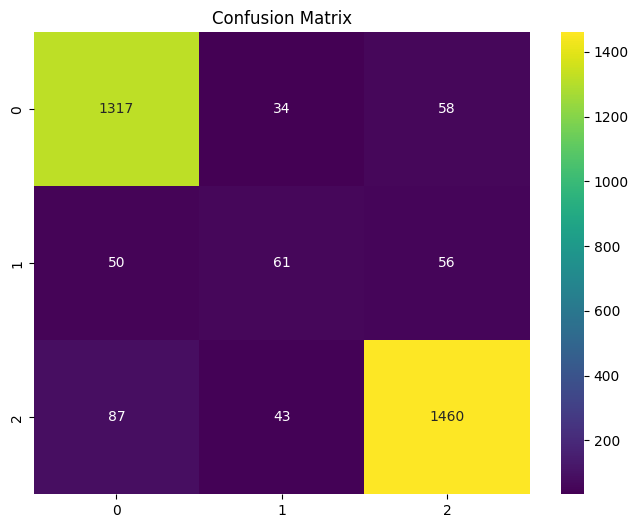

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cm = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True,  cmap='viridis', fmt='d')
plt.title('Confusion Matrix')
plt.show()

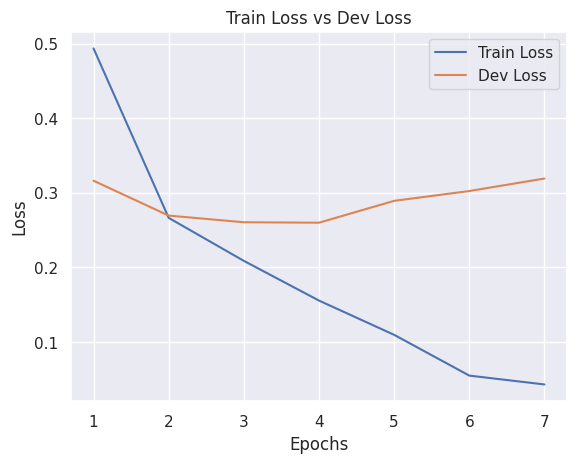

In [21]:
data = {
    "Epochs": list(range(1, n_epochs + 1)),
    "Train Loss": list_loss,
    "Train Acc": list_acc,
    "Dev Loss": list_dev_loss,
    "Dev Acc": list_dev_acc
}
df = pd.DataFrame(data)

sns.set(style="darkgrid")
sns.lineplot(data=df, x="Epochs", y="Train Loss", label="Train Loss")
sns.lineplot(data=df, x="Epochs", y="Dev Loss", label="Dev Loss")
plt.title('Train Loss vs Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

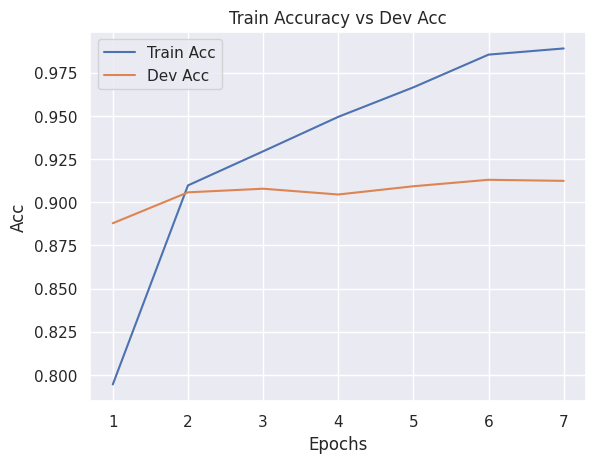

In [22]:
sns.lineplot(data=df, x="Epochs", y="Train Acc", label="Train Acc")
sns.lineplot(data=df, x="Epochs", y="Dev Acc", label="Dev Acc")
plt.title('Train Accuracy vs Dev Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()